Exposure 0: wave A, gating = True
Exposure 1: wave B, gating=False, theta=0.75
Exposure 2: wave B, gating=True, theta=3.94
Exposure 3: wave B, gating=False, theta=3.68
Exposure 4: wave B, gating=True, theta=4.65
Exposure 5: wave B, gating=False, theta=2.00
Exposure 6: wave B, gating=True, theta=2.02
Exposure 7: wave B, gating=False, theta=2.54


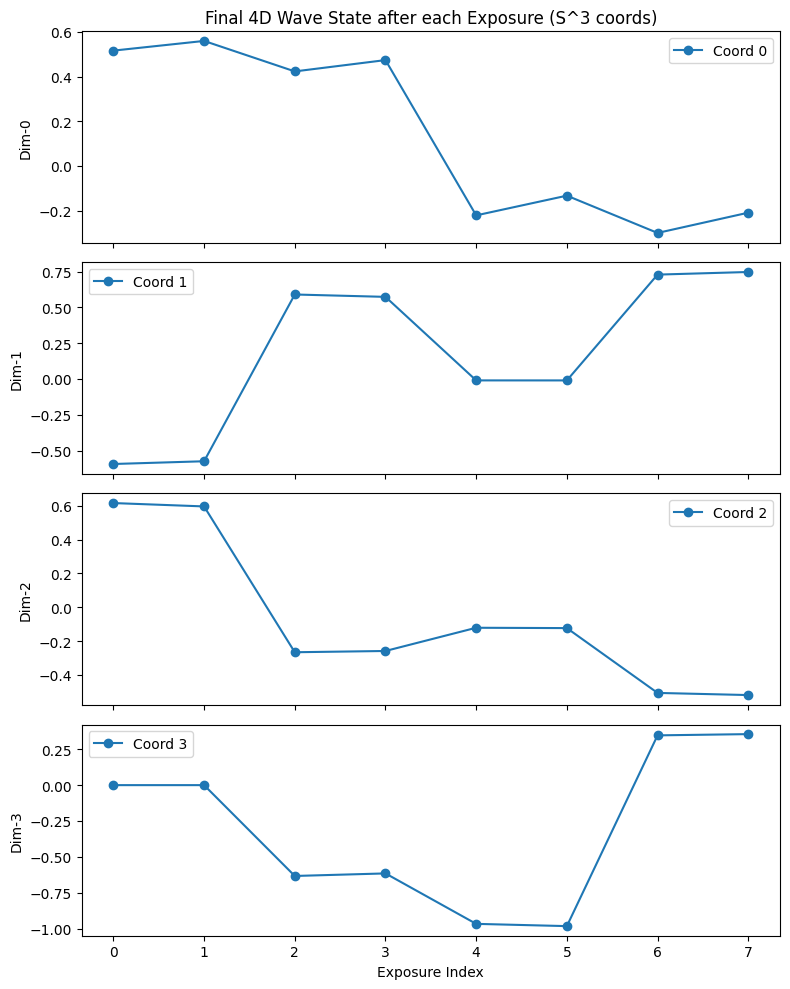

In [6]:
import numpy as np

def normalize_sphere_4d(vec):
    norm = np.linalg.norm(vec)
    if norm < 1e-12:
        return vec
    return vec / norm

def log_map_sphere_4d(p, q):
    """
    Log_{p}(q) on the unit 4D sphere (S^3).
    This returns the tangent vector at p that points toward q.
    """
    p_n = normalize_sphere_4d(p)
    q_n = normalize_sphere_4d(q)
    dot_ = np.clip(np.dot(p_n, q_n), -1.0, 1.0)
    angle = np.arccos(dot_)
    if angle < 1e-12:
        # p == q or near-collinear => zero vector
        return np.zeros_like(p)
    # direction in tangent space
    perp = q_n - dot_ * p_n
    perp_norm = np.linalg.norm(perp)
    if perp_norm < 1e-12:
        return np.zeros_like(p)
    dir_ = perp / perp_norm
    return dir_ * angle

def exp_map_sphere_4d(p, v):
    """
    Exp_{p}(v) for the unit 4D sphere.
    Move from p along the tangent vector v.
    """
    p_n = normalize_sphere_4d(p)
    norm_v = np.linalg.norm(v)
    if norm_v < 1e-12:
        return p_n
    dir_ = v / norm_v
    angle = norm_v
    # final
    new_point = np.cos(angle)*p_n + np.sin(angle)*dir_
    return normalize_sphere_4d(new_point)
def random_wave_4d(theta=0.0):
    """
    Create a 'wave' in 4D, e.g., incorporate 'theta' as part of the vector.
    We'll do something naive: 2 random coords + [cos(theta), sin(theta)] pattern.
    """
    # random coords for first 2 dims
    rand2 = np.random.randn(2)
    # embed theta in 2D polar form
    pol = np.array([np.cos(theta), np.sin(theta)])
    wave_4d = np.concatenate([rand2, pol])
    return normalize_sphere_4d(wave_4d)

class SphericalWaveLTC4D:
    def __init__(self, short_decay=0.9, long_decay=0.98):
        """
        We'll keep short_state and long_state as 4D points on S^3.
        Start at some baseline (maybe [1,0,0,0])?
        """
        self.short_state = np.array([1.0, 0.0, 0.0, 0.0])  # baseline
        self.long_state  = np.array([1.0, 0.0, 0.0, 0.0])
        self.short_decay = short_decay
        self.long_decay  = long_decay

    def partial_interference_sphere(self, base, new, alpha=1.0):
        """
        base, new: 4D vectors on S^3
        alpha: partial interference factor.
        1) we do v = Log_base(new)
        2) scale v by alpha
        3) updated = Exp_base(v_scaled)
        4) return updated
        """
        v = log_map_sphere_4d(base, new)
        v_scaled = alpha * v
        updated = exp_map_sphere_4d(base, v_scaled)
        return updated

    def update(self, input_wave, gating=True):
        """
        If gating, we do partial_interference_sphere from short+long states.
        Otherwise we do partial decay => rotate them slightly towards baseline?
        """
        if gating:
            # short update: alpha=1.0
            self.short_state = self.partial_interference_sphere(
                self.short_state, input_wave, alpha=1.0
            )
            # long update: alpha=0.8 for partial
            self.long_state = self.partial_interference_sphere(
                self.long_state, input_wave, alpha=0.8
            )
        else:
            # gating off => partial decay: rotate each state a bit toward baseline
            baseline = np.array([1.0, 0.0, 0.0, 0.0])
            self.short_state = self.partial_interference_sphere(
                self.short_state, baseline, alpha=1.0 - self.short_decay
            )
            self.long_state = self.partial_interference_sphere(
                self.long_state, baseline, alpha=1.0 - self.long_decay
            )

        # combined wave => partial_interference_sphere from short+long
        combined = self.partial_interference_sphere(
            self.short_state, self.long_state, alpha=1.0
        )
        return combined
    
import matplotlib.pyplot as plt

if __name__ == "__main__":

    # We'll do 8 exposures again
    exposures = 8
    ltc4d = SphericalWaveLTC4D(short_decay=0.9, long_decay=0.95)

    # We'll store final 4D wave after each update
    final_4d_history = []

    # First wave => unopposed
    waveA_4d = random_wave_4d(theta=0.0)  # e.g., unlearned wave
    print("Exposure 0: wave A, gating = True")
    final_4d = ltc4d.update(waveA_4d, gating=True)
    final_4d_history.append(final_4d.copy())

    # subsequent waves
    for i in range(1, exposures):
        # wave B with slight random 'theta'
        random_theta = np.random.uniform(0.0, 2*np.pi)
        waveB_4d = random_wave_4d(theta=random_theta)
        gating_signal = (i % 2 == 0)  # same gating rule: every 2 exposures
        print(f"Exposure {i}: wave B, gating={gating_signal}, theta={random_theta:.2f}")

        final_4d = ltc4d.update(waveB_4d, gating=gating_signal)
        final_4d_history.append(final_4d.copy())

    # final_4d_history has 8 4D points
    # Let's just plot their 4D coords over exposures
    arr = np.array(final_4d_history)  # shape [8, 4]
    fig, axs = plt.subplots(4,1, figsize=(8,10), sharex=True)
    for dim in range(4):
        axs[dim].plot(range(exposures), arr[:,dim], marker='o', label=f"Coord {dim}")
        axs[dim].set_ylabel(f"Dim-{dim}")
        axs[dim].legend()

    axs[0].set_title("Final 4D Wave State after each Exposure (S^3 coords)")
    axs[-1].set_xlabel("Exposure Index")
    plt.tight_layout()
    plt.show()

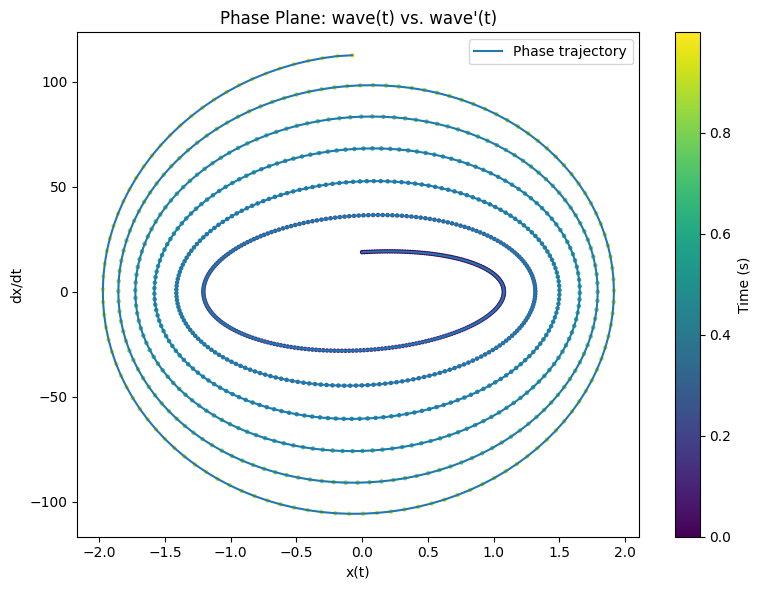

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def bending_wave(t):
    """
    Example wave: amplitude from 1..2, frequency from 3..6, no initial phase
    wave(t) = A(t) * sin( 2*pi * freq(t)*t )
    with A(t) = 1 + ratio, freq(t) = 3 + 3*ratio, ratio = t/t_end
    """
    t_end = t[-1] if len(t)>0 else 1.0
    x = np.zeros_like(t)
    for i, ti in enumerate(t):
        ratio = ti/t_end if t_end>0 else 0
        A = 1.0 + ratio
        f = 3.0 + 3.0*ratio
        x[i] = A*np.sin(2*np.pi*f*ti)
    return x

if __name__ == "__main__":
    # time array
    fs = 1000
    duration = 1.0
    t = np.linspace(0, duration, int(fs*duration), endpoint=False)

    # create wave
    x = bending_wave(t)

    # numerical derivative (dx/dt)
    # we can approximate with np.gradient / (time step)
    dt = t[1] - t[0] if len(t)>1 else 1.0
    dx = np.gradient(x, dt)

    # now we have x(t) and dx(t)
    # 2D "phase plane" => plot x(t) on x-axis, dx(t) on y-axis
    plt.figure(figsize=(8,6))
    plt.plot(x, dx, label="Phase trajectory")

    # optional: color by time or add a param arrow
    # for demonstration, let's color each point by t
    plt.scatter(x, dx, c=t, cmap="viridis", s=5)

    plt.title("Phase Plane: wave(t) vs. wave'(t)")
    plt.xlabel("x(t)")
    plt.ylabel("dx/dt")
    plt.colorbar(label="Time (s)")
    plt.legend()
    plt.tight_layout()
    plt.show()